In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")


GPU is available


### **Importing of Necessary Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(70%), Validation set(15%), and Test set(15%).

In [ ]:
import shutil

# Set the path to the ZIP file
zip_file_path = "/content/drive/MyDrive/Rice_Image_Dataset.zip"

# Set the path to the destination directory where the ZIP contents will be extracted
destination_dir = "/content/drive/MyDrive/Rice_Image_Dataset/Extracted_Data"

# Use the shutil method to extract the ZIP file
shutil.unpack_archive(zip_file_path, destination_dir, 'zip')





In [ ]:
base_ds = r'/content/drive/MyDrive/Rice_Image_Dataset/Extracted_Data/Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [ ]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 75000 files [03:45, 333.06 files/s]


In [ ]:
import os

def get_rice_images(base_ds):
    def get_files_in_dir(directory):
        return [filename for filename in os.listdir(directory) if filename.endswith('.jpg')]

    arborio = get_files_in_dir(f'{base_ds}/Arborio')
    bastmati = get_files_in_dir(f'{base_ds}/Basmati')
    ipsala = get_files_in_dir(f'{base_ds}/Ipsala')
    jasmine = get_files_in_dir(f'{base_ds}/Jasmine')
    karacadag = get_files_in_dir(f'{base_ds}/Karacadag')

    rice = [arborio, bastmati, ipsala, jasmine, karacadag]

    rice_classes = []
    for i in os.listdir('imgs/train'):
        rice_classes.append(i)

    rice_classes.sort()

    return rice, rice_classes


rice_images, rice_classes = get_rice_images(base_ds)



### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


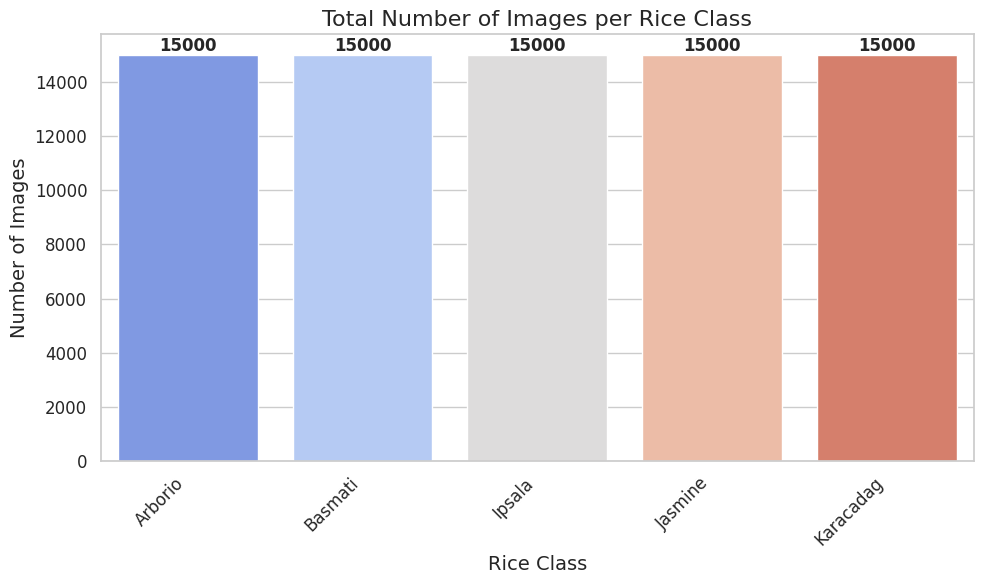

In [ ]:
from pathlib import Path# Get the list of rice class subdirectories
rice_classes = [directory.name for directory in Path(base_ds).glob('*') if directory.is_dir()]

# Function to count the number of images in each rice class
def count_images_per_class(base_ds, class_name):
    class_dir = os.path.join(base_ds, class_name)
    return len(os.listdir(class_dir))

# Get the total number of images and the count for each rice class
image_count = sum(count_images_per_class(base_ds, class_name) for class_name in rice_classes)
rice_count = [count_images_per_class(base_ds, class_name) for class_name in rice_classes]

# Display the total number of images and the count for each rice class
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')

for class_name, count in zip(rice_classes, rice_count):
    print(f'Total {class_name} images: {count}')

# Create an interesting bar plot using Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=rice_classes, y=rice_count, palette="coolwarm")
plt.title("Total Number of Images per Rice Class", fontsize=16)
plt.xlabel("Rice Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)

# Add labels to the bars
for i, count in enumerate(rice_count):
    bar_plot.text(i, count, str(count), ha='center', va='bottom', fontsize=12, weight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

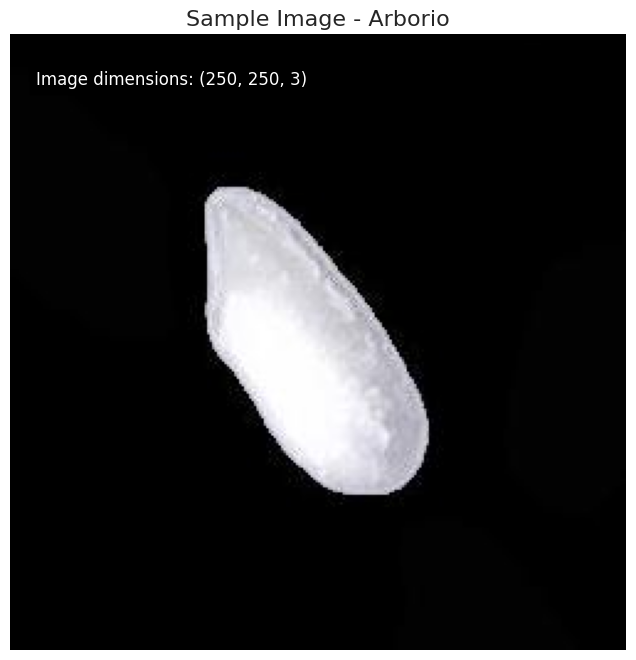

In [ ]:
# Load and display the sample image
sample_img = cv2.imread('imgs/test/Arborio/Arborio (10).jpg')
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Add a title to the image
plt.title('Sample Image - Arborio', fontsize=16)

# Remove axis ticks for a cleaner look
plt.axis('off')

# Display the image dimensions
plt.text(10, 20, f'Image dimensions: {sample_img.shape}', fontsize=12, color='white', backgroundcolor='black')

plt.show()

In [ ]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

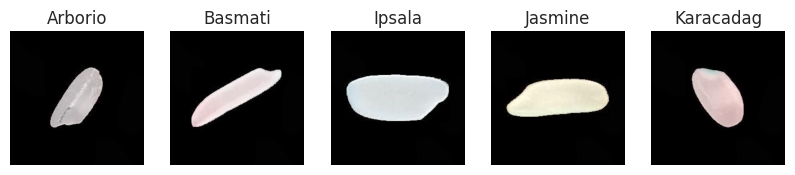

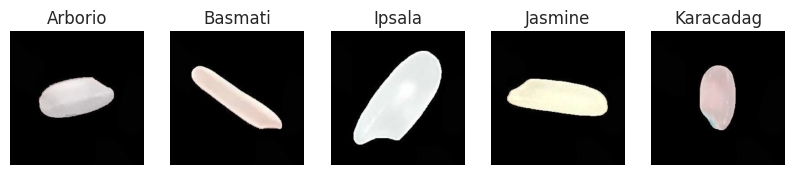

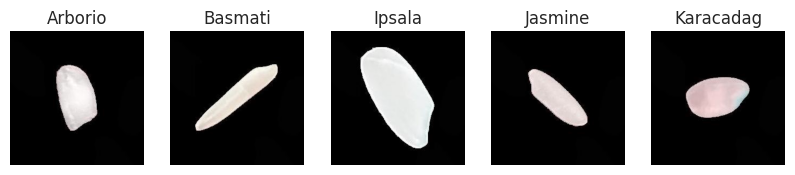

In [ ]:
for i in range(3):
  load_random_img(base_ds, rice_classes)

### **Data Pre-processing**

In [ ]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [ ]:

# Print class indices (optional)
print("Class indices for training data:", train_ds.class_indices)
print("Class indices for validation data:", val_ds.class_indices)
print("Class indices for test data:", test_ds.class_indices)


Class indices for training data: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
Class indices for validation data: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
Class indices for test data: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [ ]:
def plot_train_history(history):
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## **Vanilla CNN Model**

In [ ]:
from tensorflow.keras import layers, models
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same', strides=(1, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid', strides=(1, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming you have 5 classes
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 175, 175, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

## **Callbacks**

In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5',
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

# Train the model with callbacks
vanilla=model.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


411/411 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9487
Epoch 1: val_accuracy improved from -inf to 0.96844, saving model to saved_models/model_vanilla.hdf5
411/411 [==============================] - 144s 322ms/step - loss: 0.1461 - accuracy: 0.9487 - val_loss: 0.0909 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 2/40
411/411 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9749
Epoch 2: val_accuracy improved from 0.96844 to 0.98160, saving model to saved_models/model_vanilla.hdf5
411/411 [==============================] - 143s 349ms/step - loss: 0.0737 - accuracy: 0.9749 - val_loss: 0.0585 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 3/40
411/411 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9861
Epoch 3: val_accuracy improved from 0.98160 to 0.98400, saving model to saved_models/model_vanilla.hdf5
411/411 [==============================] - 136s 331ms/step - loss: 0.0403 - accuracy: 0.9861 - val_loss: 0.0445 - val_

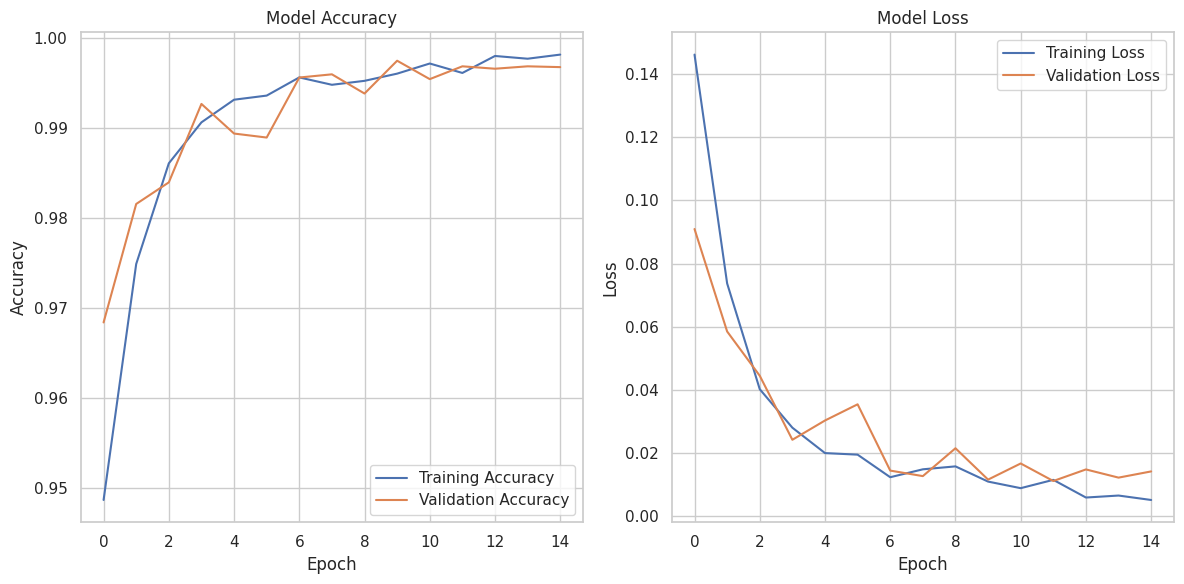

In [ ]:
model.load_weights('saved_models/model_vanilla.hdf5')
plot_train_history(vanilla)

## **Model Evaluation of Vanilla CNN**

In [ ]:
score1 = model.evaluate(test_ds, verbose=1)

88/88 [==============================] - 19s 219ms/step - loss: 0.0127 - accuracy: 0.9962


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_ds)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


88/88 [==============================] - 19s 217ms/step


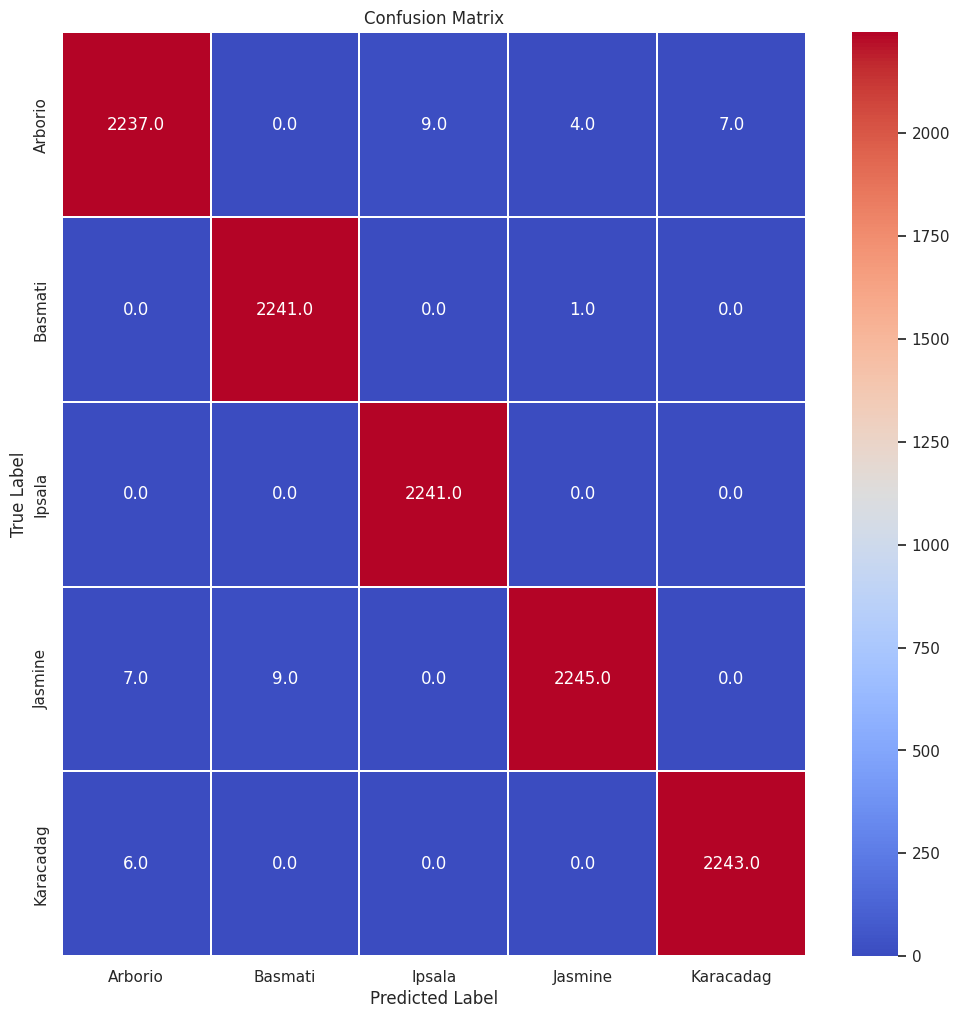

In [ ]:
# Get the predicted labels
y_pred = np.argmax(Y_pred, axis=1)

# Create the confusion matrix
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)

# Set up the plot
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, linecolor="white", fmt='.1f', cmap="coolwarm")

# Set the labels for x and y axes
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Set the tick labels for the x and y axes
ax = plt.gca()
ax.set_xticklabels(test_ds.class_indices.keys())
ax.set_yticklabels(test_ds.class_indices.keys())

# Set the title
plt.title("Confusion Matrix")

# Display the plot
plt.show()

In [ ]:
# Create the classification report
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)

# Convert the report to a DataFrame
df1 = pd.DataFrame(report1).transpose()

# Apply styling to the DataFrame for better visualization
styled_df1 = df1.style.background_gradient(cmap='coolwarm', axis=None)\
                .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]},
                                  {'selector': 'caption', 'props': [('caption-side', 'bottom')]}])\
                .set_caption("Classification Report for Rice Classes")\
                .format("{:.2f}", subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])\
                .format("{:.0f}", subset=pd.IndexSlice[:, ['support']])

# Display the styled DataFrame
styled_df1

,precision,recall,f1-score,support
Arborio,0.99,0.99,0.99,2250
Basmati,1.00,1.00,1.00,2250
Ipsala,1.00,1.00,1.00,2250
Jasmine,0.99,1.00,1.00,2250
Karacadag,1.00,1.00,1.00,2250
accuracy,1.00,1.00,1.00,1
macro avg,1.00,1.00,1.00,11250
weighted avg,1.00,1.00,1.00,11250


## **Transfer Learning**

In [ ]:
vgg16=VGG16()

553467096/553467096 [==============================] - 6s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg16.input_shape

(None, 224, 224, 3)

In [ ]:
# Load VGG16 with pre-trained weights on ImageNet
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False

# Add custom classification layers on top of VGG16
model_vgg16 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming you have 5 classes
])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5',
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history2 = model_vgg16.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks=callbacks)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


411/411 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9561
Epoch 1: val_accuracy improved from -inf to 0.98533, saving model to saved_models/model_vgg16.hdf5
411/411 [==============================] - 704s 2s/step - loss: 0.1723 - accuracy: 0.9561 - val_loss: 0.0508 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 2/20
411/411 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9864
Epoch 2: val_accuracy improved from 0.98533 to 0.99022, saving model to saved_models/model_vgg16.hdf5
411/411 [==============================] - 666s 2s/step - loss: 0.0458 - accuracy: 0.9864 - val_loss: 0.0338 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 3/20
411/411 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9896
Epoch 3: val_accuracy improved from 0.99022 to 0.99031, saving model to saved_models/model_vgg16.hdf5
411/411 [==============================] - 666s 2s/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.0322 - val_accuracy: 0.990

In [ ]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

In [ ]:
plot_train_history(history2)

In [ ]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

## **Fine Tuning**

In [ ]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = model_vgg16.fit(train_ds, epochs = 10, validation_data = val_ds, callbacks=callbacks)

404/404 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9942
Epoch 1: val_accuracy did not improve from 0.99396
404/404 [==============================] - 275s 680ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 0.0209 - val_accuracy: 0.9939 - lr: 1.0000e-05


In [ ]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

## **Final Evaluation**

In [ ]:
score3 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score3[0]}, Accuracy: {score3[1]*100}')

87/87 [==============================] - 48s 548ms/step - loss: 0.0219 - accuracy: 0.9928
Model 1 Vanilla Loss: 0.027492118999361992, Accuracy: 99.06666874885559
Model 2 VGG16 Loss: 0.024844329804182053, Accuracy: 99.18222427368164
Model 2 VGG16 Fine-tuned Loss: 0.021873174235224724, Accuracy: 99.27999973297119


In [ ]:
Y_pred = model_vgg16.predict(test_ds)

87/87 [==============================] - 47s 548ms/step


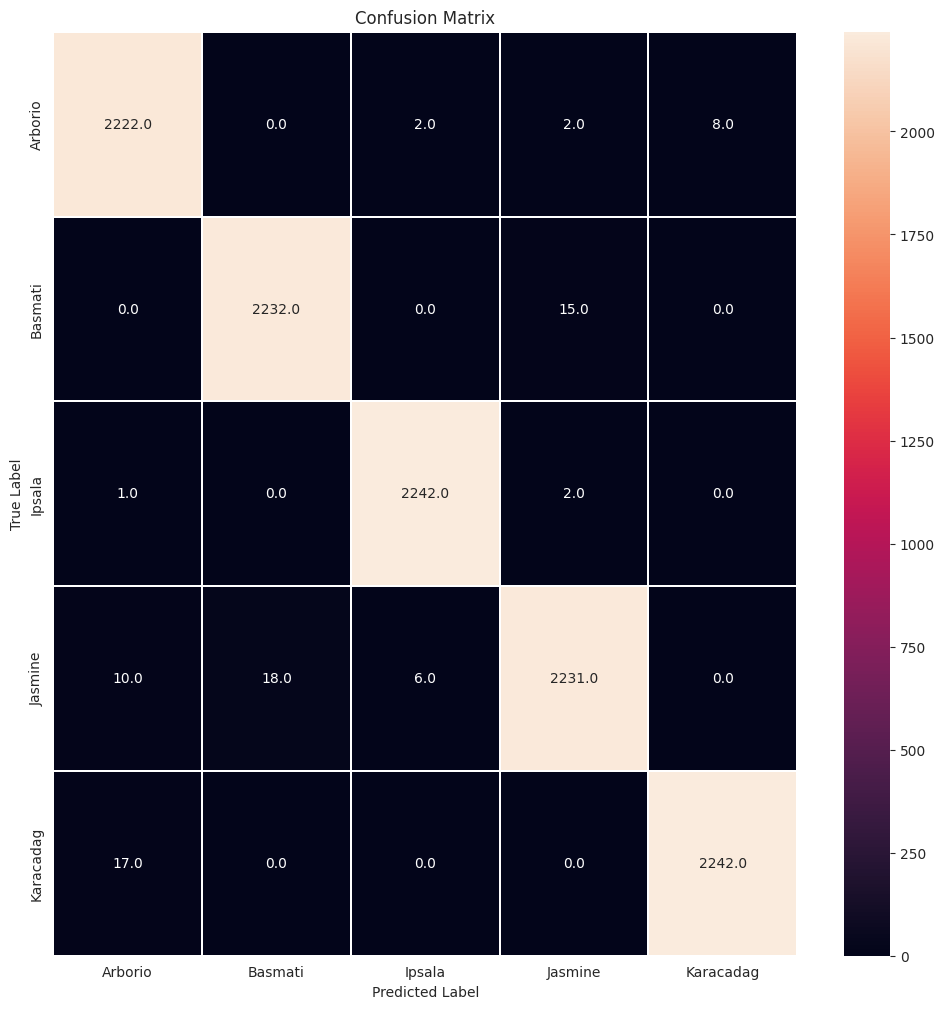

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report1).transpose()
df2

,precision,recall,f1-score,support
Arborio,0.986737,0.992000,0.989362,2250.000000
Basmati,0.999097,0.984000,0.991491,2250.000000
Ipsala,1.000000,0.987556,0.993739,2250.000000
Jasmine,0.973079,0.996000,0.984406,2250.000000
Karacadag,0.995105,0.993778,0.994441,2250.000000
accuracy,0.990667,0.990667,0.990667,0.990667
macro avg,0.990804,0.990667,0.990688,11250.000000
weighted avg,0.990804,0.990667,0.990688,11250.000000


import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3945303218329496950, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3945303218329496950, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3945303218329496950, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3945303218329496950, *['support'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3945303218329496950, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3945303218329496950, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3945303218329496950, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3945303218329496950, *['support'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945303218329496950 = autoviz.get_df('df_3945303218329496950')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_3945303218329496950, *[[['precision', 'recall'], ['recall', 'f1-score'], ['f1-score', 'support']]], **{})
chart

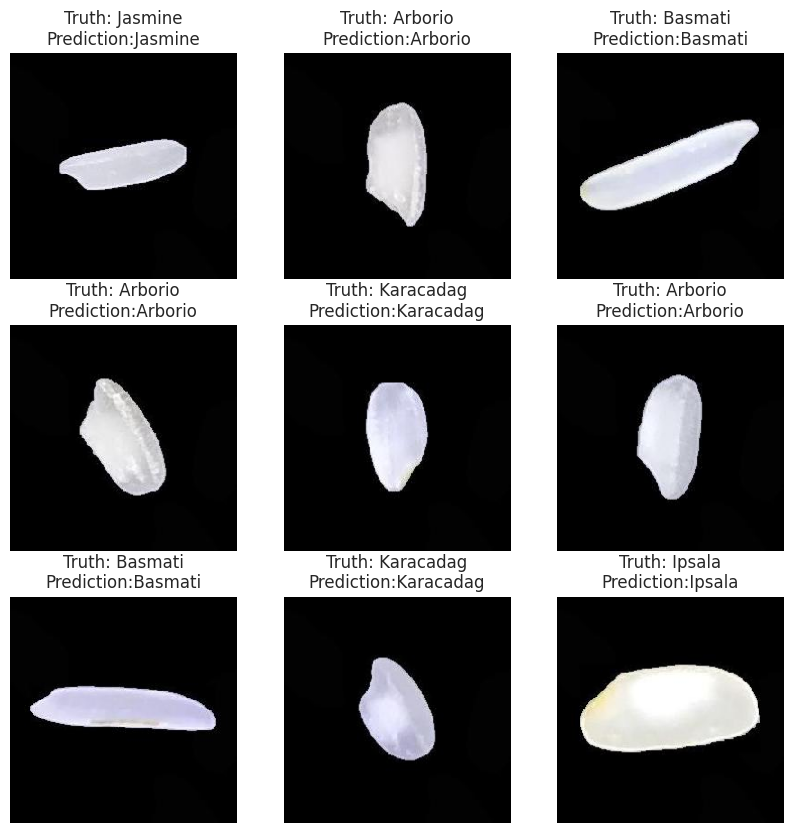

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)